In [1]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Hougang'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 4731


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128387,HOUGANG,3 ROOM,986B,BUANGKOK CRES,67.0,Model A,2012,89 years,403000.0,8.0,65.0
128388,HOUGANG,3 ROOM,126,HOUGANG AVE 1,70.0,New Generation,1983,59 years 09 months,368000.0,8.0,65.0
128389,HOUGANG,3 ROOM,117,HOUGANG AVE 1,80.0,New Generation,1982,59 years,410000.0,2.0,65.0
128390,HOUGANG,3 ROOM,415,HOUGANG AVE 10,67.0,New Generation,1985,62 years 04 months,345000.0,2.0,65.0
128391,HOUGANG,3 ROOM,412,HOUGANG AVE 10,67.0,New Generation,1985,62 years 03 months,367500.0,2.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152956,HOUGANG,EXECUTIVE,533,HOUGANG AVE 6,145.0,Apartment,1988,64 years,890888.0,5.0,76.0
152957,HOUGANG,EXECUTIVE,237,HOUGANG ST 21,150.0,Maisonette,1984,60 years 03 months,950000.0,11.0,76.0
152958,HOUGANG,EXECUTIVE,559,HOUGANG ST 51,143.0,Apartment,1992,68 years 05 months,810000.0,5.0,76.0
152959,HOUGANG,EXECUTIVE,560,HOUGANG ST 51,143.0,Apartment,1992,68 years 05 months,835000.0,11.0,76.0


In [2]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 4935
0 of 453
10 of 453
check 364A UPP SERANGOON RD. No data returned
20 of 453
30 of 453
40 of 453
50 of 453
check 365A UPP SERANGOON RD. No data returned
check 365C UPP SERANGOON RD. No data returned
check 365B UPP SERANGOON RD. No data returned
60 of 453
70 of 453
80 of 453
90 of 453
100 of 453
110 of 453
120 of 453
130 of 453
140 of 453
150 of 453
160 of 453
170 of 453
180 of 453
190 of 453
200 of 453
210 of 453
220 of 453
230 of 453
240 of 453
250 of 453
260 of 453
270 of 453
check 364B UPP SERANGOON RD. No data returned
280 of 453
290 of 453
300 of 453
check 365D UPP SERANGOON RD. No data returned
310 of 453
320 of 453
330 of 453
340 of 453
350 of 453
360 of 453
370 of 453
380 of 453
390 of 453
400 of 453
410 of 453
420 of 453
430 of 453
440 of 453
450 of 453
6 errors detected
pickle dumped. 5382


In [7]:
a = df[(df.street_name!='UPP SERANGOON RD')|(df.block=='464')]
blk_street = a.block + ' ' + a.street_name
len(blk_street.unique())
#df.describe()

447

In [8]:
df = a.copy()
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128387,HOUGANG,3 ROOM,986B,BUANGKOK CRES,67.0,Model A,2012,89 years,403000.0,8.0,65.0
128388,HOUGANG,3 ROOM,126,HOUGANG AVE 1,70.0,New Generation,1983,59 years 09 months,368000.0,8.0,65.0
128389,HOUGANG,3 ROOM,117,HOUGANG AVE 1,80.0,New Generation,1982,59 years,410000.0,2.0,65.0
128390,HOUGANG,3 ROOM,415,HOUGANG AVE 10,67.0,New Generation,1985,62 years 04 months,345000.0,2.0,65.0
128391,HOUGANG,3 ROOM,412,HOUGANG AVE 10,67.0,New Generation,1985,62 years 03 months,367500.0,2.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152956,HOUGANG,EXECUTIVE,533,HOUGANG AVE 6,145.0,Apartment,1988,64 years,890888.0,5.0,76.0
152957,HOUGANG,EXECUTIVE,237,HOUGANG ST 21,150.0,Maisonette,1984,60 years 03 months,950000.0,11.0,76.0
152958,HOUGANG,EXECUTIVE,559,HOUGANG ST 51,143.0,Apartment,1992,68 years 05 months,810000.0,5.0,76.0
152959,HOUGANG,EXECUTIVE,560,HOUGANG ST 51,143.0,Apartment,1992,68 years 05 months,835000.0,11.0,76.0


In [9]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,1213.000000,1213.000000,1.213000e+03,1213.000000,1213.000000,1213.000000,1213.000000
mean,99.606760,1994.138500,5.507566e+05,7.532564,70.399835,103.888793,1.370756
std,24.253431,12.006143,1.539643e+05,4.287518,3.424706,0.007178,0.009106
min,47.000000,1975.000000,2.850000e+05,2.000000,65.000000,103.877348,1.349177
25%,84.000000,1985.000000,4.380000e+05,5.000000,67.000000,103.882824,1.365842
50%,100.000000,1989.000000,5.200000e+05,8.000000,70.000000,103.888528,1.373673
75%,116.000000,1999.000000,6.300000e+05,11.000000,73.000000,103.893837,1.377680
max,160.000000,2018.000000,1.080000e+06,20.000000,76.000000,103.904256,1.382028


SuggestedLRs(valley=0.0014454397605732083, slide=6.309573450380412e-07)

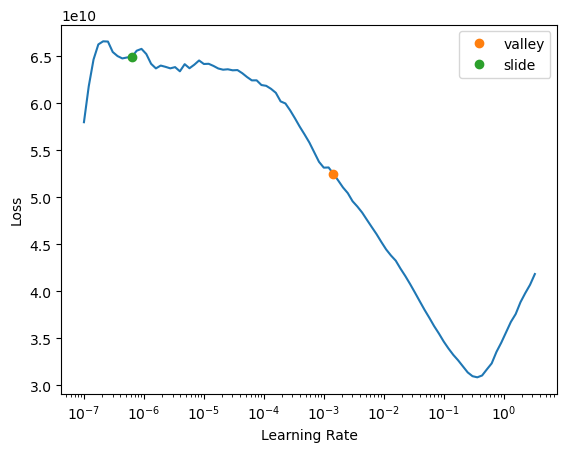

In [10]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
#dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [16]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 43966.2890625.


(#2) [1972857856.0,43966.2890625]

In [17]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 6*15
n2 = 8*15
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()
print('done!')

0 of 120
10 of 120
20 of 120
30 of 120
40 of 120
50 of 120
60 of 120
70 of 120
80 of 120
90 of 120
100 of 120
110 of 120
done!


In [18]:
import http.client, urllib.parse
import json

mrts = ["Kovan MRT", "Hougang MRT", "Buangkok MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {add}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 5573
Kovan Station, Singapore, confidence 1
Hougang Station, Singapore, confidence 1
Buangkok Station, Singapore, confidence 1
pickle dumped. 5575


In [18]:
longLats['Upper Changi MRT']

(103.96138, 1.341393)

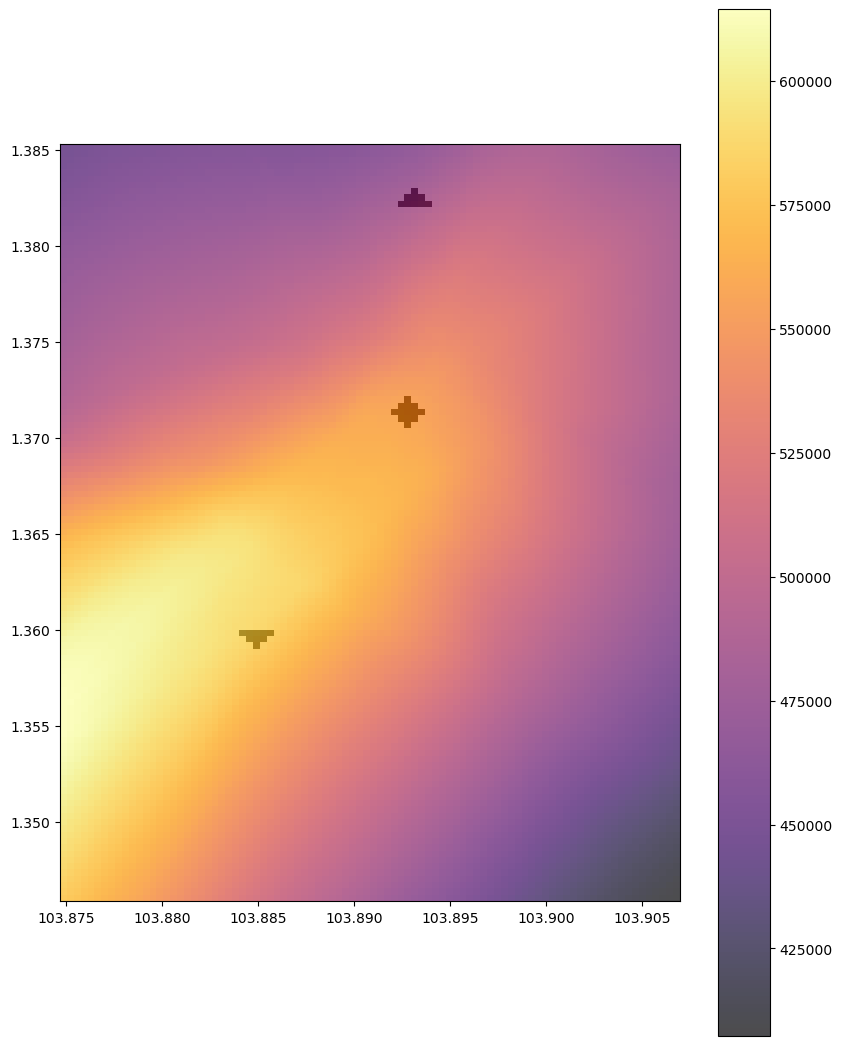

In [19]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

map_down(*min_coords(*longLats[mrts[0]]))
map_star(*min_coords(*longLats[mrts[1]]))
map_up(*min_coords(*longLats[mrts[2]]))
#map_down(*min_coords(*longLats[mrts[1]]))
#map_left(*min_coords(*longLats[mrts[2]]))
#map_right(*min_coords(*longLats[mrts[3]]))
#map_right(*min_coords(*longLats[mrts[4]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

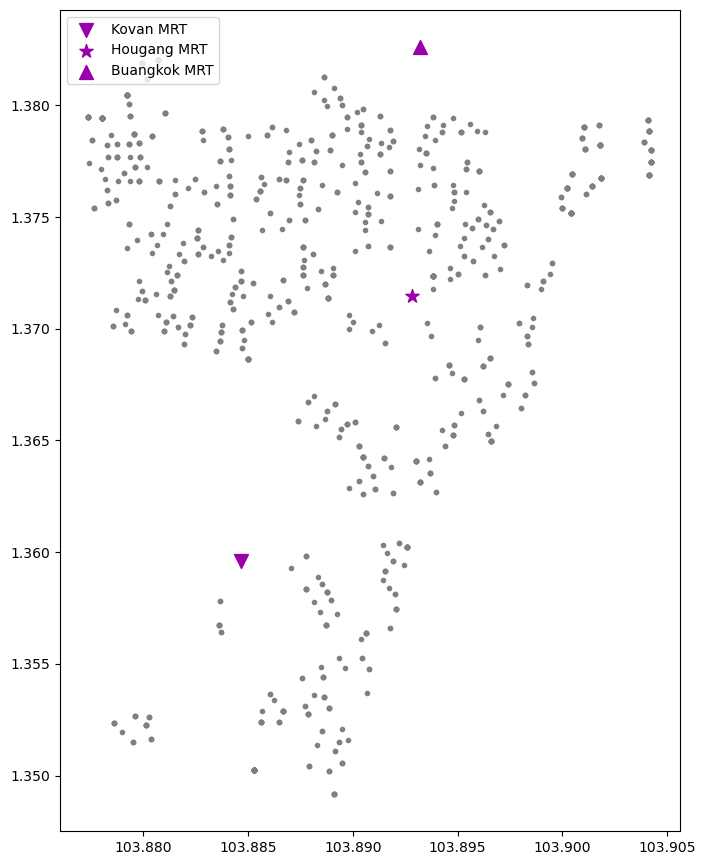

In [21]:
circle = "#FA9E0D"
ew = "#009645"
dt = "#005EC4"
red = '#d62728'
ne = '#9900AA'
markers = ["v", '*', "^", '>', '>', '^', '^']
colors = [ne,ne,ne]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.',c="gray")
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c=colors[i],label=mrt,s=100)
ax2.legend(loc='upper left')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
